### Testing out the new project

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

from src.clean import detect_na, standardize_columns, impute_nas
from src.eda import extended_describe, plot_correlation_heatmap, plot_dists, calc_vif, feat_select
from src.train import train_model
from src.tune import grand_tuner, param_spaces, dynamic_param_grid, save_best_params
from src.eval import eval_classification
from src.predict import load_trained_model, make_preds

from src.helper import save_best_params, load_best_params, serialize_params, stratified_sample, param_spaces, dynamic_param_grid

# df = pd.read_csv('../data/Breast_Cancer.csv')
df = pd.read_csv('../data/heart_attack_china.csv')

df

,Patient_ID,Age,Gender,Smoking_Status,Hypertension,Diabetes,Obesity,Cholesterol_Level,Air_Pollution_Exposure,Physical_Activity,...,Hospital_Availability,TCM_Use,Employment_Status,Education_Level,Income_Level,Blood_Pressure,Chronic_Kidney_Disease,Previous_Heart_Attack,CVD_Risk_Score,Heart_Attack
0,1,55,Male,Non-Smoker,No,No,Yes,Normal,High,High,...,Low,Yes,Unemployed,Primary,Low,104,Yes,No,78,No
1,2,66,Female,Smoker,Yes,No,No,Low,Medium,High,...,High,No,Unemployed,Secondary,Middle,142,No,No,49,No
2,3,69,Female,Smoker,No,No,No,Low,Medium,High,...,Low,No,Unemployed,Primary,High,176,No,No,31,No
3,4,45,Female,Smoker,No,Yes,No,Normal,Medium,Low,...,Medium,Yes,Employed,Primary,Low,178,No,Yes,23,No
4,5,39,Female,Smoker,No,No,No,Normal,Medium,Medium,...,Low,No,Retired,Higher,Middle,146,Yes,No,79,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239261,239262,53,Male,Non-Smoker,No,No,No,Normal,Medium,Medium,...,High,Yes,Retired,Higher,Low,167,No,No,86,Yes
239262,239263,48,Female,Non-Smoker,No,No,Yes,Normal,Low,Medium,...,Medium,Yes,Unemployed,Higher,Low,179,No,No,25,No
239263,239264,57,Male,Smoker,Yes,No,No,Normal,Low,High,...,Medium,Yes,Retired,Higher,Middle,136,No,No,89,No
239264,239265,42,Female,Non-Smoker,No,No,No,High,Medium,High,...,Low,Yes,Employed,Primary,Middle,159,No,No,72,Yes


### Cleaning and Preprocessing

In [2]:
detect_na(df)

,Columns,NA_count
0,Patient_ID,0
1,Age,0
2,Gender,0
3,Smoking_Status,0
4,Hypertension,0
5,Diabetes,0
6,Obesity,0
7,Cholesterol_Level,0
8,Air_Pollution_Exposure,0
9,Physical_Activity,0


Seems like it's mostly pristine, with one column, `Education_Level` needing to be removed.

In [2]:
df.drop(['Education_Level', 'Patient_ID'], axis='columns', inplace=True)


In [5]:
if df.isna().sum().sum() == 0: 
    print('No remaining NA vals')

No remaining NA vals


### EDA

In [3]:
# This will kick off a much larger discussion about that OHE (One Hot Encoding) and the drop_first=True argument
# It's undeniable that some information will be lost, but it can be re-created, no? 
# Yes, they can! It's tedious, but it can be done... then what's the harm? 
# Well, when there's hundreds or thousands of features, categorical reconstruction doesn't feel as feasible! 
# Exploring this concept more in a blog post; for now we'll just use get_dummies as usual

df_encoded = pd.get_dummies(df, dtype=int, drop_first=True)

df_encoded = standardize_columns(df_encoded)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239266 entries, 0 to 239265
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   age                            239266 non-null  int64
 1   blood_pressure                 239266 non-null  int64
 2   cvd_risk_score                 239266 non-null  int64
 3   gender_male                    239266 non-null  int64
 4   smoking_status_smoker          239266 non-null  int64
 5   hypertension_yes               239266 non-null  int64
 6   diabetes_yes                   239266 non-null  int64
 7   obesity_yes                    239266 non-null  int64
 8   cholesterol_level_low          239266 non-null  int64
 9   cholesterol_level_normal       239266 non-null  int64
 10  air_pollution_exposure_low     239266 non-null  int64
 11  air_pollution_exposure_medium  239266 non-null  int64
 12  physical_activity_low          239266 non-null  int64
 13 

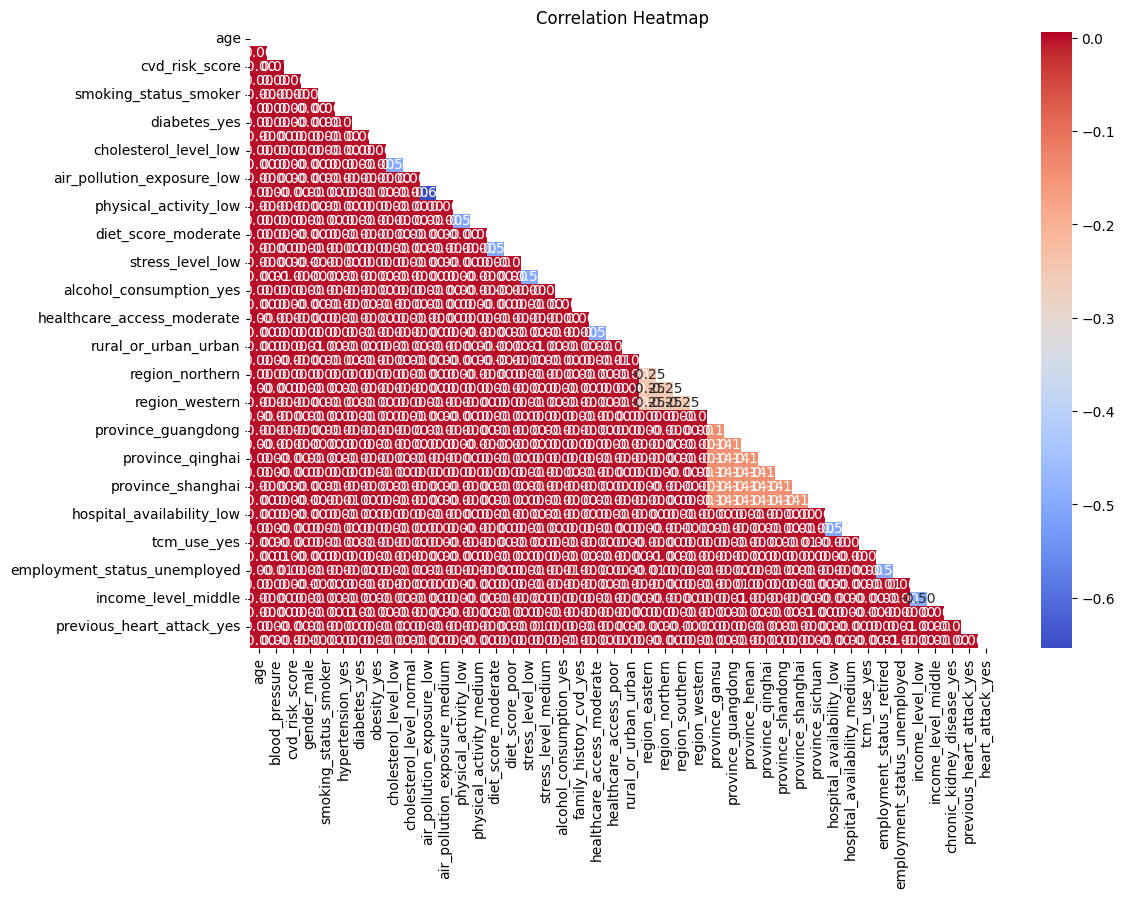

In [6]:
plot_correlation_heatmap(df_encoded)

Wow-- lots of features now, makes sense since we just performed OHE. However, there's way too much going on here, it needs to be cut down. I'll use my ElasticNet automatic feature selection function from `eda.py`

In [6]:
# Heart Attacks as target

selected_feats = feat_select(df_encoded, target='heart_attack_yes', smote_enabled=True)

⚠️ Imbalanced data detected 
(Minority class = 12.15%) 
Applying SMOTE...

ElasticNet Feature Selection Summary
SMOTE enabled
Original feature count: 43
Selected feature count: 40 (🔻3 trimmed)
Best Alpha: 4.17e-03
Best L1 Ratio: 0.60
Final Selected Features:
['gender_male', 'smoking_status_smoker', 'hypertension_yes', 'diabetes_yes', 'obesity_yes', 'cholesterol_level_low', 'cholesterol_level_normal', 'air_pollution_exposure_low', 'air_pollution_exposure_medium', 'physical_activity_low', 'physical_activity_medium', 'diet_score_moderate', 'diet_score_poor', 'stress_level_low', 'stress_level_medium', 'alcohol_consumption_yes', 'family_history_cvd_yes', 'healthcare_access_moderate', 'healthcare_access_poor', 'rural_or_urban_urban', 'region_eastern', 'region_northern', 'region_southern', 'region_western', 'province_gansu', 'province_guangdong', 'province_henan', 'province_qinghai', 'province_shandong', 'province_shanghai', 'province_sichuan', 'hospital_availability_low', 'hospital_availabil

In [20]:
summary_stats = extended_describe(df_encoded) 
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,239266.0,59.466284,17.348308,30.0,44.0,59.0,75.0,89.0,0.002302,-1.204728
blood_pressure,239266.0,134.513378,25.991827,90.0,112.0,135.0,157.0,179.0,-0.001079,-1.201560
cvd_risk_score,239266.0,54.485581,25.987743,10.0,32.0,54.0,77.0,99.0,0.000369,-1.200624
gender_male,239266.0,0.498683,0.499999,0.0,0.0,0.0,1.0,1.0,0.005266,-1.999989
smoking_status_smoker,239266.0,0.499733,0.500001,0.0,0.0,0.0,1.0,1.0,0.001070,-2.000016
hypertension_yes,239266.0,0.270448,0.444192,0.0,0.0,0.0,1.0,1.0,1.033580,-0.931721
diabetes_yes,239266.0,0.110638,0.313684,0.0,0.0,0.0,0.0,1.0,2.482526,4.162970
obesity_yes,239266.0,0.299855,0.458195,0.0,0.0,0.0,1.0,1.0,0.873633,-1.236776
cholesterol_level_low,239266.0,0.332496,0.471109,0.0,0.0,0.0,1.0,1.0,0.711111,-1.494333
cholesterol_level_normal,239266.0,0.334736,0.471899,0.0,0.0,0.0,1.0,1.0,0.700426,-1.509416


In [6]:
calc_vif(df_encoded[selected_feats])

NameError: name 'selected_feats' is not defined

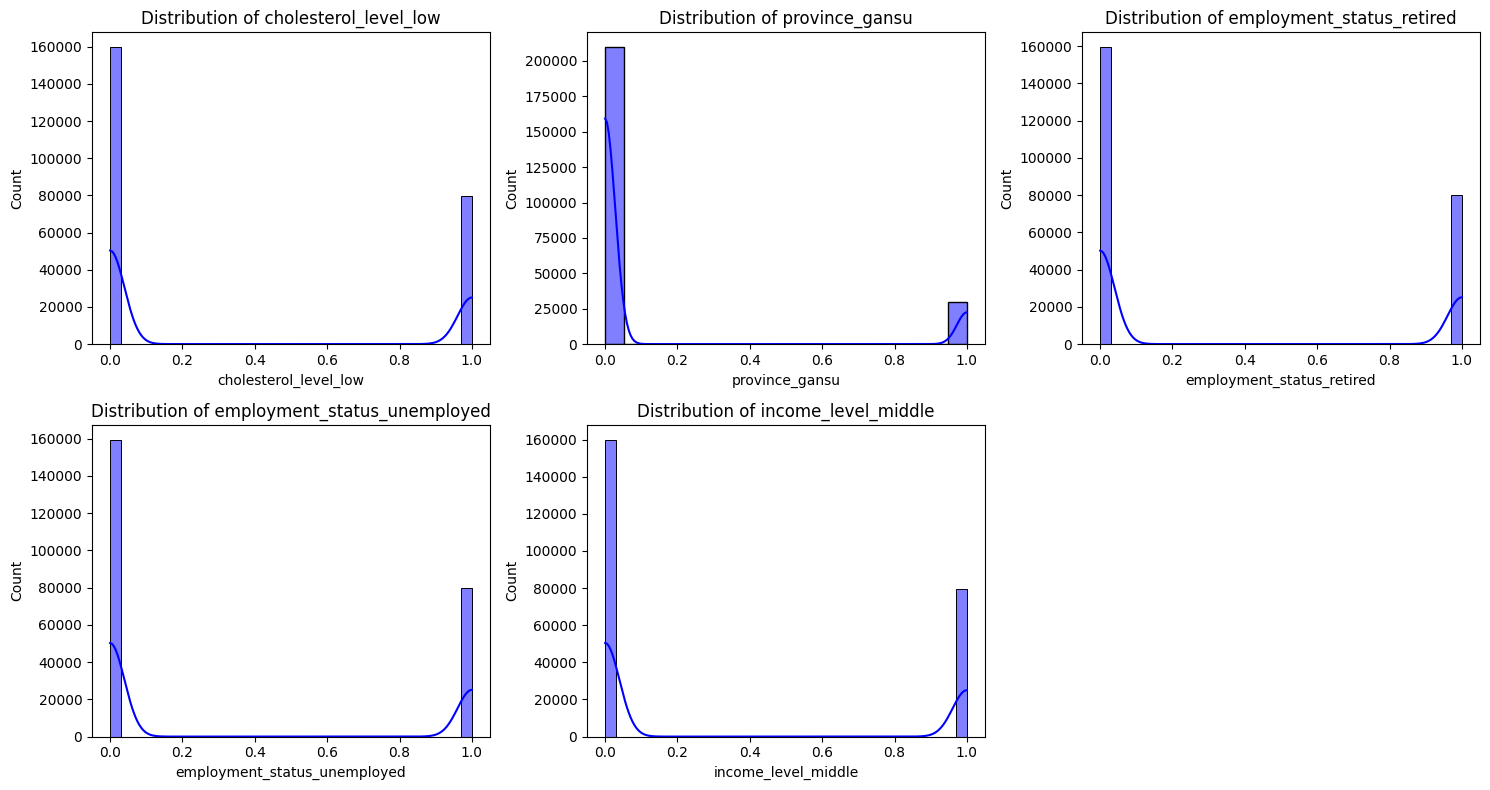

In [10]:
plot_dists(df_encoded[selected_feats], selected_feats)

### Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_encoded.drop(columns=['heart_attack_yes'])
y = df_encoded['heart_attack_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#-------------------
# SMOTE because unbalanced training data 
# smote = SMOTE(random_state=10)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# y_train.value_counts()

## Randomized Search --> GridSearch
Similar concept to using a Mixture Model to find optimal centroids, then plugging those same centroids into KMeans, which will run 100x faster. 

1. RandomizedSearchCV-- explores a broad parameter space without testing every single combination. It's the advance troops, narrowing down the scope  

2. GridSearchCV-- Focuses on the most promising regions found in step 1, fine-tuning the best params

In [ ]:
# March 21st-- 5:46pm

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time

# THIS IS INTENTIONALLY OUTSIDE
# Might make this global later, still deciding
param_spaces = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [50, 100, 200, 300, 500],
        "classifier__max_depth": [None, 10, 20, 30, 50],
        "classifier__min_samples_split": [2, 5, 10, 20],
        "classifier__min_samples_leaf": [1, 2, 5, 10],
        "classifier__max_features": ["sqrt", "log2", None]
    },
    "XGBClassifier": {
        "classifier__n_estimators": [50, 100, 200, 300],
        "classifier__max_depth": [3, 6, 9, 12],
        "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "classifier__subsample": [0.5, 0.7, 1.0],
        "classifier__colsample_bytree": [0.5, 0.7, 1.0]
    },
    "LogisticRegression": {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"]
    }
}

def dynamic_param_grid(model, best_params):
    '''
    Refines hyperparameter search speace for GridSearchCV, based on model type
    
    Args:
        model: trained model object (RandomForest, XGBoost, LinearRegression)
        best_params: best paramters found from RandomizedSearchCV
        
    Returns:
        redefined_param_grid: param grid that is dependent on the `model`
    '''

    model_name = model.__class__.__name__
    if model_name not in param_spaces:
        raise ValueError(f"Model {model_name} is not yet supported by the `grand_tuner`.")
    
    refined_grid = {}

    try:
        # RF -- n_estimators and max_depth
        if model_name == "RandomForestClassifier":
            refined_grid = {
                "classifier__n_estimators": [
                    max(best_params["classifier__n_estimators"] - 50, 50),  
                    best_params["classifier__n_estimators"],  
                    best_params["classifier__n_estimators"] + 50
                ],
                "classifier__max_depth": [
                    best_params["classifier__max_depth"] - 10 if best_params["classifier__max_depth"] else None,
                    best_params["classifier__max_depth"],
                    best_params["classifier__max_depth"] + 10 if best_params["classifier__max_depth"] else None
                ]
            }
        
        # XGB -- n_estimators, learning_rate
        elif model_name == "XGBClassifier":
            refined_grid = {
                "classifier__n_estimators": [
                    max(best_params["classifier__n_estimators"] - 50, 50),  
                    best_params["classifier__n_estimators"],  
                    best_params["classifier__n_estimators"] + 50
                ],
                "classifier__learning_rate": [
                    max(best_params["classifier__learning_rate"] - 0.01, 0.01),
                    best_params["classifier__learning_rate"],
                    min(best_params["classifier__learning_rate"] + 0.01, 0.5)
                ]
            }

        # LR -- C, penalty
        elif model_name == "LogisticRegression":
            refined_grid = {
                "classifier__C": [
                    max(best_params["classifier__C"] / 10, 0.001),
                    best_params["classifier__C"],
                    min(best_params["classifier__C"] * 10, 1000)
                ],
                "classifier__penalty": [best_params["classifier__penalty"]] 
            }
    
    # If all else fails, revert to param_spaces (default) 
    except KeyError as e:
        print(f"⚠️ Missing expected param in best_params: {e}")
        print("Using default grid for fallback.")

        refined_grid = param_spaces[model_name]

    return refined_grid

#-------------------------------------------------------

def grand_tuner(model, param_grid, X, y, cv=5, scoring='roc_auc', use_smote=True, n_iter=20):
    '''
    Performs hyperparameter tuning using a two-step approach:
    1. RandomizedSearchCV to explore a broad parameter space
    2. GridSearchCV to fine-tune the best found region

    Args:
        model: the classifier to be tuned
        param_grid: dictionary of hyperparameters
        X: features
        y: target labels
        cv: number of Cross-Validation folds
        scoring: evaluation metric (roc_auc)
        use_smote: whether to apply SMOTE for class-balancing
        n_iter: number of iterations for RandomizedSearchCV (20)

    Returns: 
        best_model: model with optimal hyperparams
        best_params: dictionary of best hyperparams
    '''

    print(f"\nStarting Grand Tuner with {cv}-fold Cross-Validation...")
    print(f"Model: {model.__class__.__name__}")
    print(f"Scoring metric: {scoring}")
    print(f"SMOTE Enabled: {use_smote}")
    print(f"Running RandomizedSearchCV with {n_iter} iterations...")

    if param_grid is None:
        param_grid = param_spaces.get(model.__class__.__name__, {})
        print(f"Using default param grid for {model.__class__.__name__}: {param_grid}")

    # Pipeline with optional SMOTE
    steps = []
    if use_smote:
        steps.append(('smote', SMOTE(random_state=10)))

    steps.extend([('scaler', MinMaxScaler()), ('classifier', model)])
    pipeline = imbpipeline(steps)

    # Cross-validation strategy
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=10)

    # Step 1: RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scoring,
        cv=stratified_kfold,
        n_jobs=-1,
        verbose=1,
        random_state=10
    )
   
    # Timing the Random Search
    start_random = time.time()
    random_search.fit(X, y)
    end_random = time.time()
    print(f"⏱️ RandomizedSearchCV completed in {(end_random - start_random)/60:.2f} minutes")


    # Get best parameters from RandomizedSearch
    best_random_params = random_search.best_params_
    print(f"\n🎲 Best Parameters from RandomizedSearch: {best_random_params}")

    refined_grid = dynamic_param_grid(model, best_random_params)
    print(f"\n🛠️ Running GridSearchCV with refined parameters: {refined_grid}")

    # Step 2: GridSearchCV 
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=refined_grid, 
        scoring=scoring, 
        cv=stratified_kfold, 
        n_jobs=4, 
        verbose=1
    ) 

    # Timing the Grid Search
    start_grid = time.time()
    grid_search.fit(X, y)
    end_grid = time.time()
    print(f"⏱️ GridSearchCV completed in {(end_grid - start_grid)/60:.2f} minutes")


    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_

    print("=" * 50)
    print(f"\n✅ Best Model Found: {best_model}")
    print(f"🏆 Best Hyperparameters: {best_params}")
    print(f"📊 Best {scoring}: {grid_search.best_score_:.4f}")

    return best_model, best_params, cv_results

## TESTING THE GRAND TUNER

In [17]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=10)

# Pass None to use default grid from param_spaces
best_model, best_params, cv_results = grand_tuner(
    model=rf_model,
    param_grid=None,  # Uses default
    X=X,
    y=y,
    cv=2,  # Start small
    scoring='roc_auc',
    use_smote=True,
    n_iter=2  # Start small, scale later
)


Starting Grand Tuner with 2-fold Cross-Validation...
Model: RandomForestClassifier
Scoring metric: roc_auc
SMOTE Enabled: True
Running RandomizedSearchCV with 2 iterations...
Using default param grid for RandomForestClassifier: {'classifier__n_estimators': [50, 100, 200, 300, 500], 'classifier__max_depth': [None, 10, 20, 30, 50], 'classifier__min_samples_split': [2, 5, 10, 20], 'classifier__min_samples_leaf': [1, 2, 5, 10], 'classifier__max_features': ['sqrt', 'log2', None]}
Fitting 2 folds for each of 2 candidates, totalling 4 fits
⏱️ RandomizedSearchCV completed in 22.18 minutes

🎲 Best Parameters from RandomizedSearch: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None, 'classifier__max_depth': 50}
🛠️ Running GridSearchCV with refined parameters: {'classifier__n_estimators': [450, 500, 550], 'classifier__max_depth': [40, 50, 60]}
Fitting 2 folds for each of 9 candidates, totalling 18 fits
⏱️ Grid

In [53]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'RandomForest': (RandomForestClassifier, {'class_weight':'balanced'}),
    'XGBoost': (XGBClassifier, None)
}

trained_models = train_model(X_train, y_train, models)

# Accessing the trained model:
rf_model = trained_models['RandomForest']
xgb_model = trained_models['XGBoost']

Training Models...
Training RandomForest(RandomForestClassifier) with params: {'class_weight': 'balanced'}...
✅ RandomForest training complete! Model saved to ../models\RandomForest.pkl

Training XGBoost(XGBClassifier) with params: default settings...
✅ XGBoost training complete! Model saved to ../models\XGBoost.pkl



In [55]:
eval_classification(xgb_model, X_test, y_test)


Evaluating Model: XGBClassifier
Hyperparameters:
{
    "objective": "binary:logistic",
    "base_score": null,
    "booster": null,
    "callbacks": null,
    "colsample_bylevel": null,
    "colsample_bynode": null,
    "colsample_bytree": null,
    "device": null,
    "early_stopping_rounds": null,
    "enable_categorical": false,
    "eval_metric": null,
    "feature_types": null,
    "feature_weights": null,
    "gamma": null,
    "grow_policy": null,
    "importance_type": null,
    "interaction_constraints": null,
    "learning_rate": null,
    "max_bin": null,
    "max_cat_threshold": null,
    "max_cat_to_onehot": null,
    "max_delta_step": null,
    "max_depth": null,
    "max_leaves": null,
    "min_child_weight": null,
    "missing": NaN,
    "monotone_constraints": null,
    "multi_strategy": null,
    "n_estimators": null,
    "n_jobs": null,
    "num_parallel_tree": null,
    "random_state": null,
    "reg_alpha": null,
    "reg_lambda": null,
    "sampling_method": null

# Now Testing `tune_and_train_full()`

In [4]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['heart_attack_yes'])
y = df_encoded['heart_attack_yes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from src.run_pipeline import tune_and_train_full


rf_model, best_params = tune_and_train_full(
    model_class=RandomForestClassifier,
    model_name='RandomForest',
    X_train=X_train,
    y_train=y_train,
    model_params={'class_weight': 'balanced'},
    X_test=X_test,
    y_test=y_test,
    sample_frac=0.01, # VERY SMALL FOR TESTING
    scoring='roc_auc',
    use_smote=True,
    n_iter=2, # VERY SMALL FOR TESTING
    cv=2 # VERY SMALL FOR TESTING
)


🔍 Sampled 1914 rows (1.0%)
Class distribution:
heart_attack_yes
0    1681
1     233

Starting Grand Tuner | CV: 2 | Scoring: roc_auc
Model: RandomForestClassifier | SMOTE: True | Random Iterations: 2

**RandomForestClassifier param grid is None, using default

Fitting 2 folds for each of 2 candidates, totalling 4 fits
⏱️ RandomizedSearchCV completed in 0.07 minutes

Fitting 2 folds for each of 9 candidates, totalling 18 fits
⏱️ GridSearchCV completed in 0.06 minutes

🏆 Best Hyperparameters: {
  "classifier__n_estimators": 250,
  "classifier__min_samples_split": 5,
  "classifier__min_samples_leaf": 5,
  "classifier__max_features": "sqrt",
  "classifier__max_depth": 20
}

📊 Best roc_auc: 0.5216
💾 Saved best params for RandomForestClassifier to ../tuned_params\RandomForestClassifier_best_params.json


[TRAINING] Starting model training...

→ Training RandomForest with params:
{
    "class_weight": "balanced",
    "classifier__n_estimators": 250,
    "classifier__min_samples_split": 5,
   

c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f